# The Method

In [1]:
!pip install activeSVC==4.0.1


In [11]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity, min_acquisition
import pandas as pd
import pickle
import os, psutil
import resource


def text_create(path, name, msg):
    full_path = path + "/" + name + '.pickle'
    f=open(full_path,'wb') 
    pickle.dump(msg,f)
    f.close()

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        return elapsed_time
        



# Download and Load PBMC Data

In [2]:
import urllib.request
import shutil

with urllib.request.urlopen("https://caltech.box.com/shared/static/wqvm0d9irzb7tneb16q01fnr4dt6cvl0.csv") as response, open('./PBMCnorm_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mxnl3tu0p8ta6zehdutjg8vxpppv3t8v.csv") as response, open('./labels_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)

with urllib.request.urlopen("https://caltech.box.com/shared/static/mysl5kjfq6p87ib7zygrpc61b8jyxt3g.csv") as response, open('./genes_final.csv', "wb") as out_file:
    shutil.copyfileobj(response, out_file)


In [4]:
data_df = pd.read_csv('./PBMCnorm_final.csv')
label_df=pd.read_csv('./labels_final.csv',header = None)
gene_df=pd.read_csv('./genes_final.csv')
classes=[0,1,2,3,4]
keys=['Monocytes','T cells','Act. T/NK','B cells','Others']

raw_data=data_df.values
target=label_df.values.reshape((raw_data.shape[1],)).astype(np.uint8)-1
gene=gene_df.values.reshape((raw_data.shape[0],))
data=normalize(np.transpose(raw_data),axis=1, norm='l2')
del data_df,label_df,gene_df,raw_data


idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

print(type(data))
print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))
for i in np.unique(target):
    print('class '+keys[i]+': '+str(np.count_nonzero((target==i)*1)))

<class 'numpy.ndarray'>
(10194, 6915) (10194,) 5
(8155, 6915)
(2039, 6915)
class Monocytes: 3269
class T cells: 3517
class Act. T/NK: 1265
class B cells: 995
class Others: 1148


# min_complexity

## Define Parameters and Work Space

In [8]:
'''
Parameters
'''
num_features = 20
num_samples=20
init_samples=100
balance=False

folder='results/min_complexity'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_complexity failed
Successfully created the directory results/min_complexity/test_20_20 


## Select Genes and Save Results

Elapsed time: 2.8066 seconds
feature 0 : gene [6006]  100 samples
training error=2.181483752299203 test error=2.1893084845512507
training accuracy=0.6318822808093194 test accuracy=0.6238352133398725
Elapsed time: 1.8439 seconds
feature 1 : gene 882  120 samples
training error=1.728877988963826 test error=1.7224129475232957
training accuracy=0.6920907418761496 test accuracy=0.68563021088769
Elapsed time: 1.9792 seconds
feature 2 : gene 5475  140 samples
training error=1.558185162477008 test error=1.5262383521333986
training accuracy=0.7751072961373391 test accuracy=0.7768513977439921
Elapsed time: 2.0256 seconds
feature 3 : gene 4719  160 samples
training error=1.3927651747394236 test error=1.4217753800882786
training accuracy=0.7959534028203556 test accuracy=0.7900931829328102
Elapsed time: 2.1553 seconds
feature 4 : gene 870  178 samples
training error=1.3607602697731453 test error=1.3987248651299657
training accuracy=0.8111587982832618 test accuracy=0.8028445316331535
Elapsed time: 2

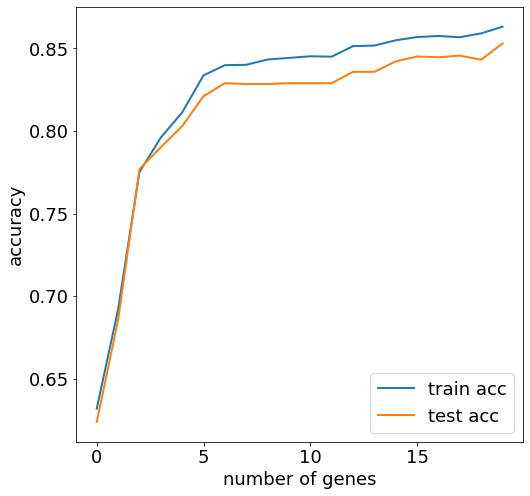

In [12]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores, step_times= min_complexity(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_samples=init_samples, balance=balance)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

# min_aquisition

## Define Parameters and Work Space

In [14]:
'''
Parameters
'''
num_features = 50
num_samples=100
init_samples=200

folder='results/min_acquisition'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Successfully created the directory results/min_acquisition 
Successfully created the directory results/min_acquisition/test_50_100 


## Select Genes and Save Results

Elapsed time: 4.5143 seconds
feature 0 : gene [6006]  200 samples
training error=2.181483752299203 test error=2.1893084845512507
training accuracy=0.6318822808093194 test accuracy=0.6238352133398725
Elapsed time: 5.3436 seconds
feature 1 : gene 2230  228 samples
training error=1.9244635193133046 test error=1.9063266307013242
training accuracy=0.696014714898835 test accuracy=0.6777832270720942
Elapsed time: 6.8018 seconds
feature 2 : gene 452  247 samples
training error=1.5385652973635806 test error=1.5875429131927414
training accuracy=0.7372164316370325 test accuracy=0.7170181461500735
Elapsed time: 7.7051 seconds
feature 3 : gene 6203  262 samples
training error=1.4188841201716738 test error=1.441883276115743
training accuracy=0.8237890864500307 test accuracy=0.8126532614026484
Elapsed time: 9.0023 seconds
feature 4 : gene 1829  305 samples
training error=1.4562844880441448 test error=1.5007356547327122
training accuracy=0.8282035561005519 test accuracy=0.8116723884256989
Elapsed time

Elapsed time: 15.6739 seconds
feature 42 : gene 5852  363 samples
training error=0.9903126916002453 test error=0.9803825404610103
training accuracy=0.8909871244635194 test accuracy=0.8847474252084355
Elapsed time: 15.8497 seconds
feature 43 : gene 2083  363 samples
training error=0.9727774371551196 test error=0.9681216282491417
training accuracy=0.891477621091355 test accuracy=0.8847474252084355
Elapsed time: 9.9184 seconds
feature 44 : gene 2572  364 samples
training error=0.9677498467198038 test error=0.9641981363413438
training accuracy=0.8927038626609443 test accuracy=0.885728298185385
Elapsed time: 7.2513 seconds
feature 45 : gene 3764  365 samples
training error=0.9666462293071735 test error=0.9475232957332026
training accuracy=0.8928264868179031 test accuracy=0.8862187346738597
Elapsed time: 12.6628 seconds
feature 46 : gene 6732  365 samples
training error=0.9648068669527897 test error=0.9337910740559098
training accuracy=0.8936848559166156 test accuracy=0.8881804806277587
Elap

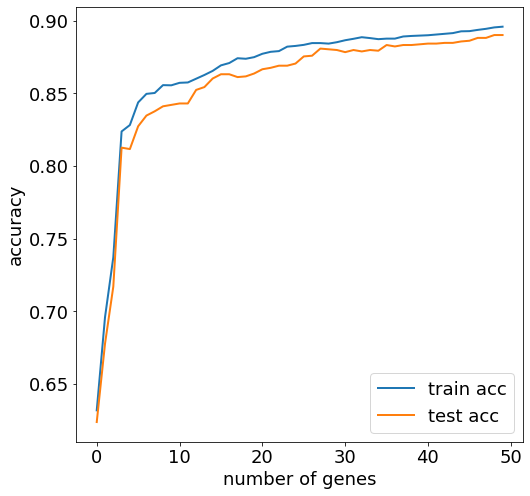

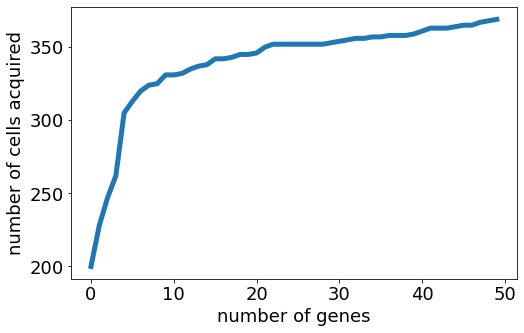

In [15]:
if __name__ == '__main__':

    t=Timer()
    t.start()
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores,step_times= min_acquisition(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples, init_samples=init_samples)
    elapsed_time=t.stop()
    
    memorys=[]
    memorys.append(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)
    memorys.append(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/ 1024 ** 2)
    
    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene[feature_selected])
    text_create(path,'elapsed_time',elapsed_time)
    text_create(path,'memory',memorys)

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(8,5))
    plt.plot(num_samples_list,linewidth=5)
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('number of cells acquired',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/cells.pdf', bbox_inches="tight")

# T-SNE of Results

## T-SNE of Original Dataset

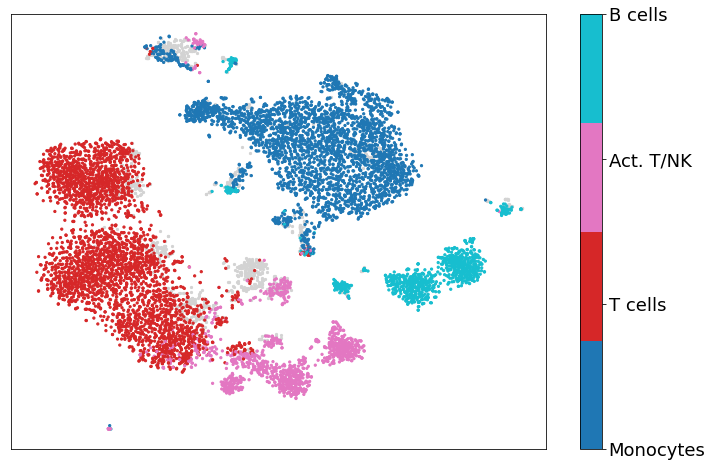

In [17]:
plt.figure(figsize=(12,8))

pca=PCA(n_components=int(X_train.shape[1]/100),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)

Y=TSNE(n_components=2).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y[others,0], Y[others,1], c='lightgray', s=5)
plt.scatter(Y[cells,0],Y[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")

f=open(path+'/tsne.pickle','wb') 
pickle.dump(Y,f)
f.close()

## T-SNE with All Genes Selected

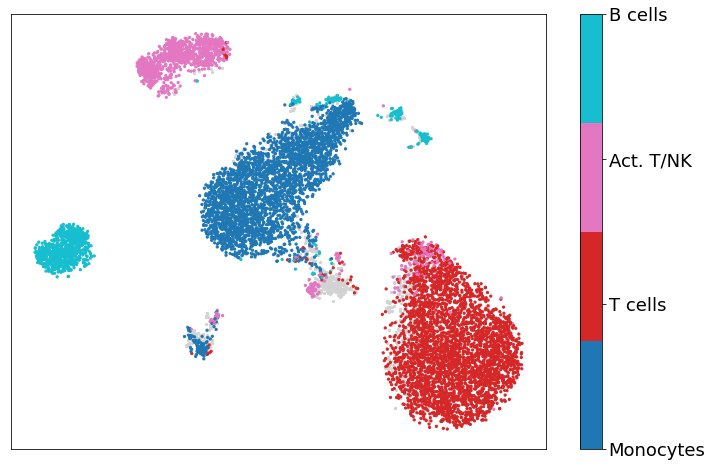

In [18]:
plt.figure(figsize=(12,8))
data_selected=data[:,feature_selected]

pca=PCA(n_components=7,
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data_selected)

Y_selected=TSNE(n_components=2,perplexity=200,early_exaggeration=1).fit_transform(pcaproj)

others=list(np.where(target==4)[0])
cells=list(np.where(target!=4)[0])

c_cmap = plt.get_cmap('tab10', len(classes)-1)
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s=5)
plt.scatter(Y_selected[cells,0],Y_selected[cells,1],c=target[cells],s=5,cmap=c_cmap)
cbar=plt.colorbar(ticks=np.arange(len(classes)-1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys[:-1],fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_wPCA.pdf',bbox_inches="tight")

f=open(path+'/tsne_selected_wPCA.pickle','wb') 
pickle.dump(Y_selected,f)
f.close()

## T-SNE of Each Gene

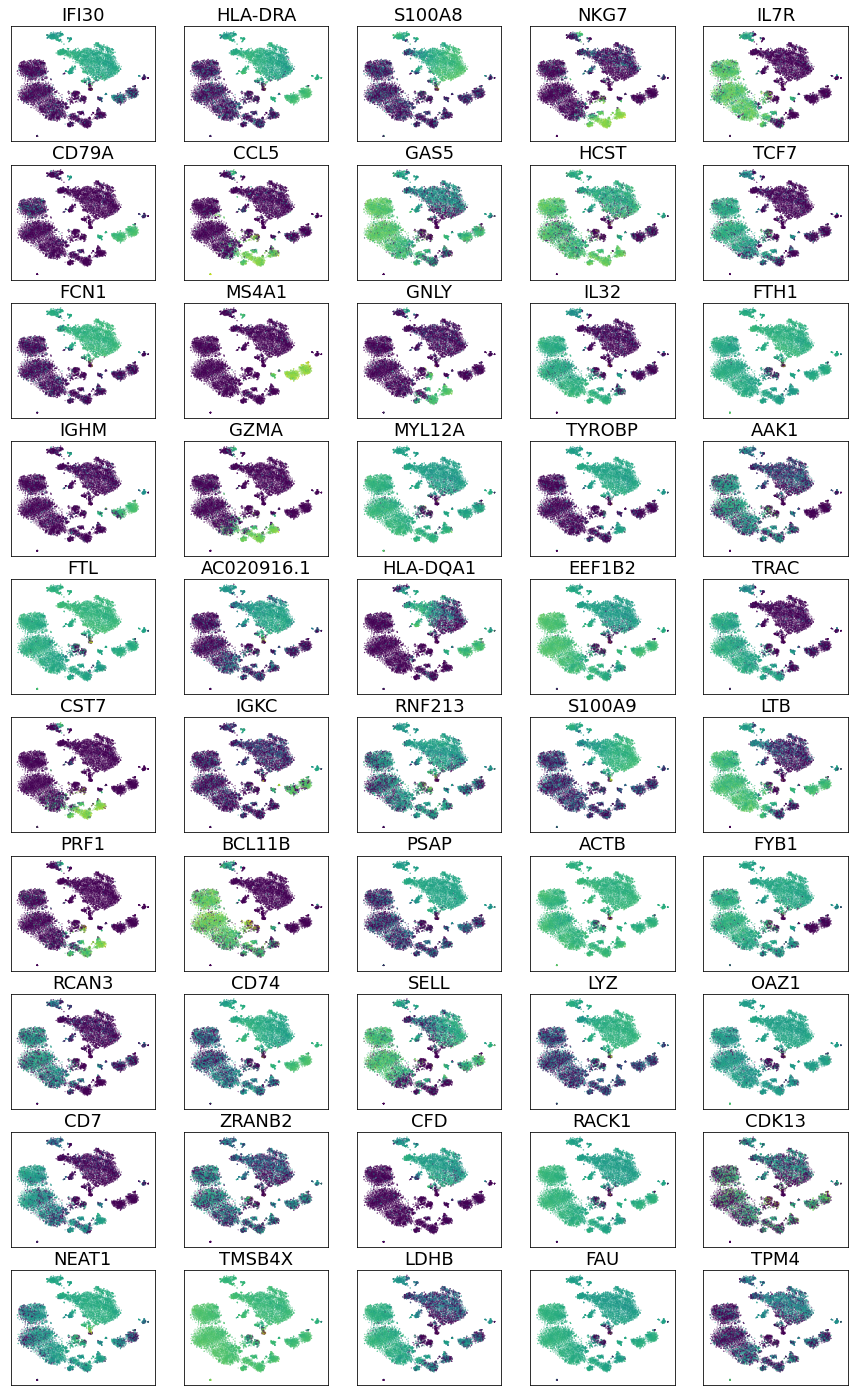

In [19]:
alpha = 100
data_show = np.log1p(data*alpha)

size=len(feature_selected)
plt.figure(figsize=(15,2.5*int(size/5)))
gs = gridspec.GridSpec(int(size/5), 5, width_ratios=[7,7,7,7,7])

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(Y[:,0],Y[:,1],c=data_show[:,f],s=0.05)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/gene.png',dpi=300,  bbox_inches="tight")    